In [360]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [361]:
import matplotlib.pyplot as plt

try:
	if "science" not in plt.style.available:
		try:
			import scienceplots  # registers styles if installed
		except Exception:
			# Install SciencePlots (registers the 'science' style) and import it
			get_ipython().run_line_magic('pip', 'install -q SciencePlots')
			import scienceplots  # noqa: F401
	plt.style.use(["science", "grid"])
except Exception as e:
	# If anything fails, fall back to a commonly available style
	print("Warning: 'science' style not available. Using 'seaborn' instead. Error:", e)
	plt.style.use("seaborn")

Bilayer unit domain. Sigma optimisation

In [362]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
from dolfinx.geometry import bb_tree
from dolfinx import geometry
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

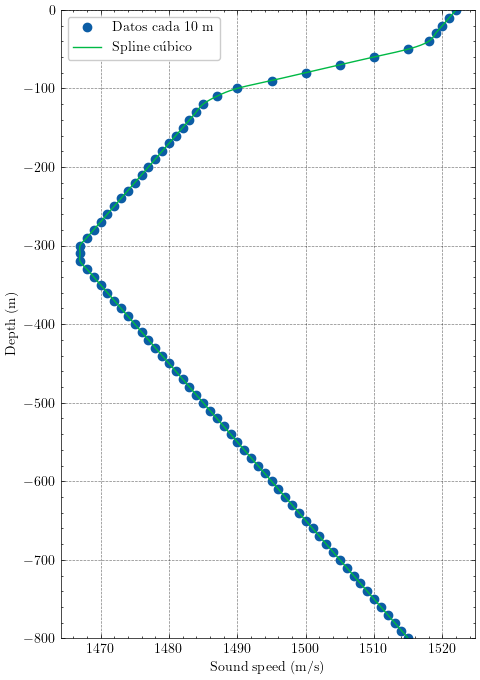

In [363]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# -----------------------------
# Datos sintéticos
# -----------------------------
depth = np.arange(0, -801, -10)          # 0 a -800 m cada 10 m
depth_pos = -depth                        # spline en coordenada positiva

sound_speed = np.array([
    1522,1521,1520,1519,1518,
    1515,1510,1505,1500,1495,
    1490,1487,1485,1484,1483,
    1482,1481,1480,1479,1478,
    1477,1476,1475,1474,1473,
    1472,1471,1470,1469,1468,
    1467,1467,1467,1468,1469,
    1470,1471,1472,1473,1474,
    1475,1476,1477,1478,1479,
    1480,1481,1482,1483,1484,
    1485,1486,1487,1488,1489,
    1490,1491,1492,1493,1494,
    1495,1496,1497,1498,1499,
    1500,1501,1502,1503,1504,
    1505,1506,1507,1508,1509,
    1510,1511,1512,1513,1514,
    1515
])

# -----------------------------
# Spline cúbico
# -----------------------------
cs = CubicSpline(depth_pos, sound_speed, bc_type="natural")

depth_fine = np.linspace(0, 800, 801)     # resolución 1 m
sound_speed_spline = cs(depth_fine)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(5,7))
plt.plot(sound_speed, depth, 'o', label="Datos cada 10 m")
plt.plot(sound_speed_spline, -depth_fine, '-', label="Spline cúbico")
plt.gca().invert_yaxis()
plt.xlabel("Sound speed (m/s)")
plt.ylabel("Depth (m)")
plt.ylim([-800,0])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [364]:
cs(100) #evaluacións con profundidade en positivo, importante porque vou crear a malla de 0 a 800

array(1490.)

Domain, PML, refinement and physical configurations

In [365]:
# Define element size for the mesh refinement
h_i = [0.125/2]

# Domain configuration
Lx = 800. # fluid domain length (without PML)

# Physical configuration
rho_media_1 = 1. # kg/m^3 



# Define the density and velocity functions  
def rho_function(x):    
    return rho_media_1+x[0]*0.

def vel_function(x):   
    return cs(x[0]) # Use the spline function to evaluate velocity at x[0]

# PML configuration
pml_thickness = Lx/8
pml_profile = 'quadratic' # 'piecewise', 'quadratic', 'singular'
sigma_0_piecewise = 16
sigma_0_quadratic = 200 #61
sigma_0_singular = 1.
# Solver configuration
requested_eigenvalues_number = 30 # Number of eigenvalues to compute

Solver configuration and computing

In [366]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Define the subdomains using a Python function
    TOL = 1e-6
    def pml_domain(x):
        """Returns True for points in (Lx, Lx + pml_thickness]"""
        return x[0] > Lx - TOL

    # Get topology dimension
    tdim = mesh.topology.dim

    # Locate cells in each subdomain
    pml_cells = locate_entities(mesh, tdim, pml_domain)

    # Create a meshtag to mark the subdomains
    num_cells = mesh.topology.index_map(tdim).size_local
    cell_markers = np.ones(num_cells, dtype=np.int32) # Physical domain tag=1
    cell_markers[pml_cells] = 2       # PML domain tag=2

    cell_tags = meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)

    # Now you can use these tags for integration measures
    dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 0))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q)
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx(2), -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx(2)],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert"
    solver.setTarget(target)
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [367]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    return p_h, v_h

In [368]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [369]:
def get_eigenpair(solver, index, Q, V, dof, mesh):

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vr, vi = solver.getOperators()[0].getVecs()
    omega_h=solver.getEigenpair(index, vr) * 1j
    bb = bb_tree(mesh, mesh.topology.dim)

    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    [p_h, v_h]=assign_eigenvector_to_functions(vrA = vr, p_h = p_h, v_h = v_h, dof = dof)
    val_Lx = eval_point_fast(p_h, bb, Lx, mesh)
    p_h.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    val_Lx = eval_point_fast(v_h, bb, Lx, mesh)
    v_h.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    return omega_h, p_h, v_h


quadratic

In [370]:
degree=[2,1]  # Polynomial degree for pressure and velocity

In [371]:
# Create mesh depending on h
mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[0]), [0, Lx + pml_thickness])

sigma_function_piecewise = lambda x: sigma_0_piecewise

sigma_function_quadratic = lambda x: sigma_0_quadratic * (x[0] - Lx)**2 / (pml_thickness**2)

sigma_function_singular = lambda x: sigma_0_singular/(Lx+pml_thickness-x[0])
# Define solver for piecewise PML
[solver_piecewise, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_function_piecewise, -5j)
[solver_quadratic, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_function_quadratic, -5j)
[solver_singular, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_function_singular, -5j)

nconv = min(solver_piecewise.getConverged(), solver_quadratic.getConverged(), solver_singular.getConverged())
# Initialize lists to store the approximated eigenpairs
approx_eigs_piecewise = [None] * nconv
approx_eigs_quadratic = [None] * nconv
approx_eigs_singular = [None] * nconv
approx_p_piecewise = [None] * nconv
approx_v_piecewise = [None] * nconv
approx_p_quadratic = [None] * nconv
approx_v_quadratic = [None] * nconv
approx_p_singular = [None] * nconv
approx_v_singular = [None] * nconv

for j in np.arange(0, nconv,1):
    # Get the approximated eigenpair
    [approx_eigs_piecewise[j], approx_p_piecewise[j], approx_v_piecewise[j]] = get_eigenpair(solver_piecewise, j, Q_, V_, dof_, mesh)
    [approx_eigs_quadratic[j], approx_p_quadratic[j], approx_v_quadratic[j]] = get_eigenpair(solver_quadratic, j, Q_, V_, dof_, mesh)
    [approx_eigs_singular[j], approx_p_singular[j], approx_v_singular[j]] = get_eigenpair(solver_singular, j, Q_, V_, dof_, mesh)
    # print(approx_eigs_piecewise[j], approx_eigs_quadratic[j], approx_eigs_singular[j])

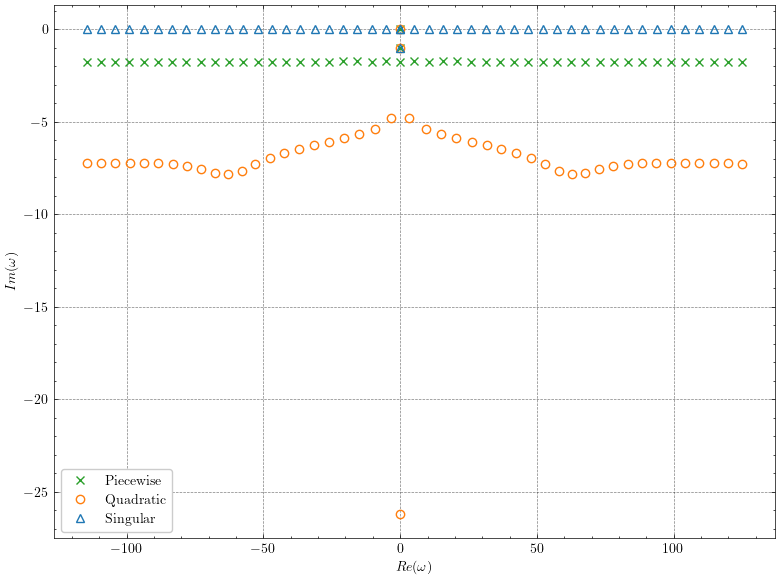

In [372]:
import matplotlib.pyplot as plt

# Definir colores manualmente (puedes elegir otros o usar un colormap como plt.cm.tab10)
colors = ['tab:green', 'tab:orange', 'tab:blue']  # uno por eig
fig= plt.figure(figsize=(8, 6))
plt.plot(np.real(approx_eigs_piecewise), np.imag(approx_eigs_piecewise), 'x', color=colors[0], markerfacecolor='none', label='Piecewise')
plt.plot(np.real(approx_eigs_quadratic), np.imag(approx_eigs_quadratic), 'o', color=colors[1], markerfacecolor='none', label='Quadratic')
plt.plot(np.real(approx_eigs_singular), np.imag(approx_eigs_singular), '^', color=colors[2], markerfacecolor='none', label='Singular')

plt.xlabel('$Re(\omega)$')
plt.ylabel(r'$Im(\omega)$')
plt.grid(True)
# plt.xlim([0,40])
# plt.ylim([-5,0])
plt.legend()
plt.tight_layout()
plt.show()

(5.155327404619521-1.7376014522630565j) (3.2859459892420952-4.805339607455596j) (5.178361731183161-0.0112639170014452j)


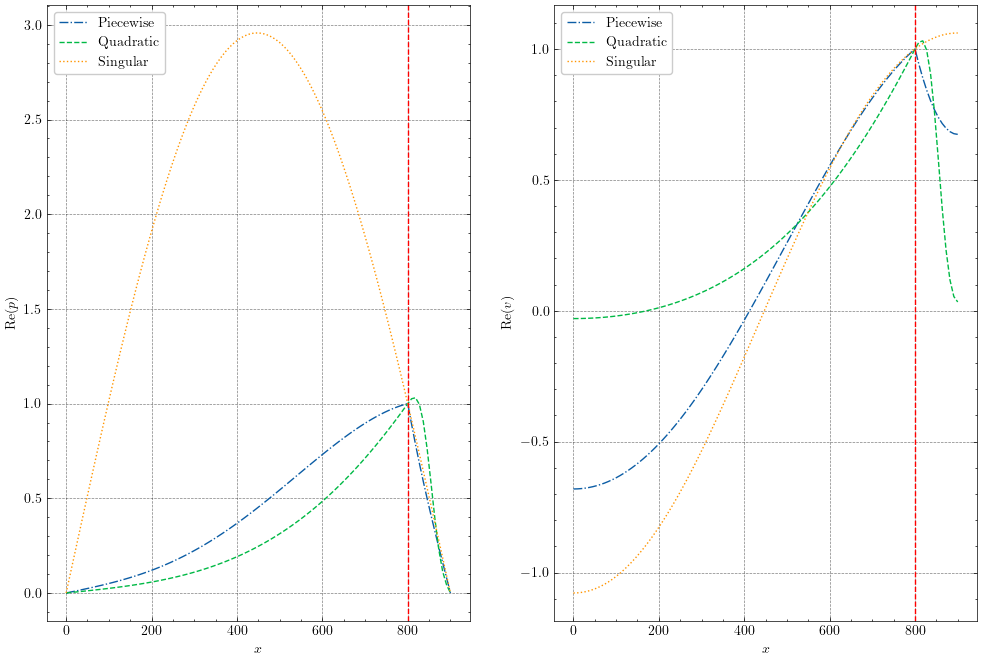

In [373]:
idx=0
print(approx_eigs_piecewise[idx], approx_eigs_quadratic[idx], approx_eigs_singular[idx])
bb = bb_tree(mesh, mesh.topology.dim)

# Extract FunctionSpace objects from the approximated functions
Q = approx_p_piecewise[0].ufl_function_space()
V = approx_v_piecewise[0].ufl_function_space()

fig, axes = plt.subplots(1, 2, figsize=(12,8))
# --- p, modo 0 ---
ax = axes[0]
xx = np.linspace(0, Lx+pml_thickness, 100)

yy_piecewise = [eval_point_fast(approx_p_piecewise[idx], bb, x, mesh) for x in xx]
yy_quadratic = [eval_point_fast(approx_p_quadratic[idx], bb, x, mesh) for x in xx]
yy_singular = [eval_point_fast(approx_p_singular[idx], bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy_piecewise), label="Piecewise", linestyle="-.")
ax.plot(xx, np.real(yy_quadratic), label="Quadratic", linestyle="--")
ax.plot(xx, np.real(yy_singular), label="Singular", linestyle=":")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$\mathrm{Re}(p)$")

# ax.set_ylim([-1.5, 1.5])
ax.grid(True)
ax.axvline(x=800, linestyle='--', color='red')

ax = axes[1]
xx = np.linspace(0, Lx+pml_thickness, 100)     
yy_piecewise = [eval_point_fast(approx_v_piecewise[idx], bb, x, mesh) for x in xx]
yy_quadratic = [eval_point_fast(approx_v_quadratic[idx], bb, x, mesh) for x in xx]
yy_singular = [eval_point_fast(approx_v_singular[idx], bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy_piecewise), label="Piecewise", linestyle="-.")
ax.plot(xx, np.real(yy_quadratic), label="Quadratic", linestyle="--")
ax.plot(xx, np.real(yy_singular), label="Singular", linestyle=":")
ax.set_xlabel("$x$")
ax.set_ylabel("$$\mathrm{Re}(v)$$")
ax.grid(True)
# ax.set_ylim([-1.5, 1.5])
ax.legend()
ax.axvline(x=800, linestyle='--', color='red')
plt.show()


(10.391387128992696-1.7436281970777063j) (-1.0956782130477905e-06-26.207773128364774j) (10.398148941348431-0.011325351236737023j)


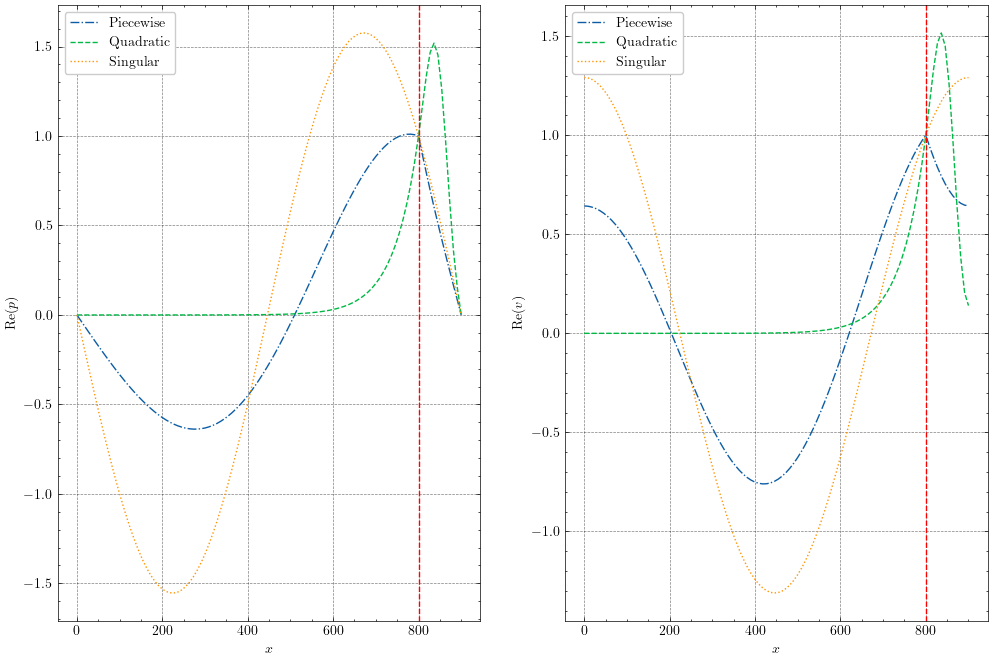

In [374]:
idx=4
print(approx_eigs_piecewise[idx], approx_eigs_quadratic[idx], approx_eigs_singular[idx])
bb = bb_tree(mesh, mesh.topology.dim)

# Extract FunctionSpace objects from the approximated functions
Q = approx_p_piecewise[0].ufl_function_space()
V = approx_v_piecewise[0].ufl_function_space()

fig, axes = plt.subplots(1, 2, figsize=(12,8))
# --- p, modo 0 ---
ax = axes[0]
xx = np.linspace(0, Lx+pml_thickness, 100)

yy_piecewise = [eval_point_fast(approx_p_piecewise[idx], bb, x, mesh) for x in xx]
yy_quadratic = [eval_point_fast(approx_p_quadratic[idx], bb, x, mesh) for x in xx]
yy_singular = [eval_point_fast(approx_p_singular[idx], bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy_piecewise), label="Piecewise", linestyle="-.")
ax.plot(xx, np.real(yy_quadratic), label="Quadratic", linestyle="--")
ax.plot(xx, np.real(yy_singular), label="Singular", linestyle=":")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$\mathrm{Re}(p)$")

# ax.set_ylim([-1.5, 1.5])
ax.grid(True)
ax.axvline(x=800, linestyle='--', color='red')

ax = axes[1]
xx = np.linspace(0, Lx+pml_thickness, 100)     
yy_piecewise = [eval_point_fast(approx_v_piecewise[idx], bb, x, mesh) for x in xx]
yy_quadratic = [eval_point_fast(approx_v_quadratic[idx], bb, x, mesh) for x in xx]
yy_singular = [eval_point_fast(approx_v_singular[idx], bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy_piecewise), label="Piecewise", linestyle="-.")
ax.plot(xx, np.real(yy_quadratic), label="Quadratic", linestyle="--")
ax.plot(xx, np.real(yy_singular), label="Singular", linestyle=":")
ax.set_xlabel("$x$")
ax.set_ylabel("$$\mathrm{Re}(v)$$")
ax.grid(True)
# ax.set_ylim([-1.5, 1.5])
ax.legend()
ax.axvline(x=800, linestyle='--', color='red')
plt.show()


(15.617201311522493-1.737471841827023j) (15.026330265177481-5.648274069962532j) (15.617670572208704-0.011282202445792247j)


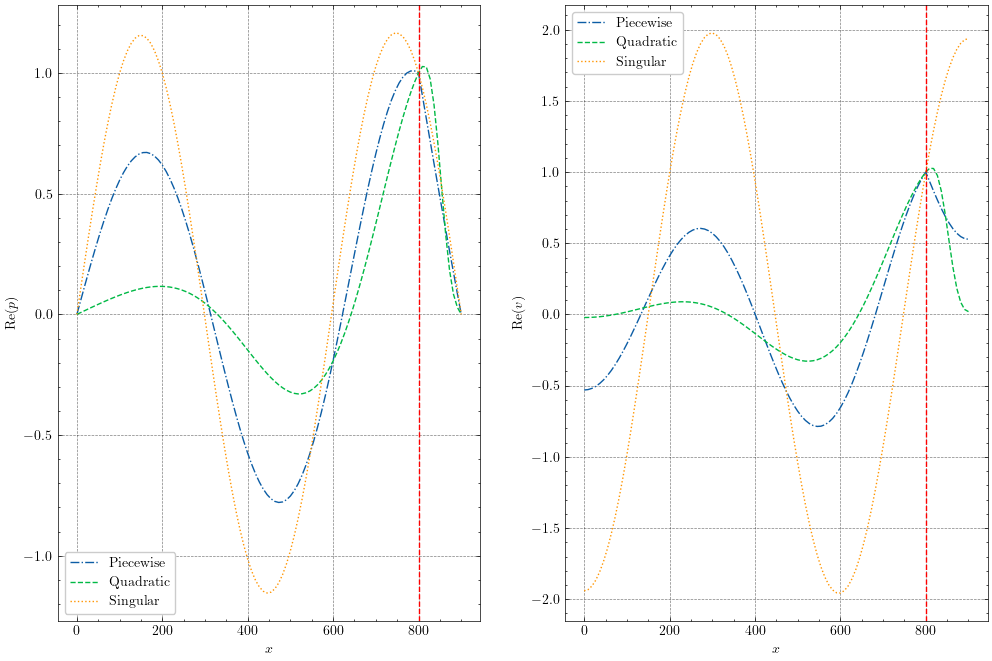

In [375]:
idx=6
print(approx_eigs_piecewise[idx], approx_eigs_quadratic[idx], approx_eigs_singular[idx])
bb = bb_tree(mesh, mesh.topology.dim)

# Extract FunctionSpace objects from the approximated functions
Q = approx_p_piecewise[0].ufl_function_space()
V = approx_v_piecewise[0].ufl_function_space()

fig, axes = plt.subplots(1, 2, figsize=(12,8))
# --- p, modo 0 ---
ax = axes[0]
xx = np.linspace(0, Lx+pml_thickness, 100)

yy_piecewise = [eval_point_fast(approx_p_piecewise[idx], bb, x, mesh) for x in xx]
yy_quadratic = [eval_point_fast(approx_p_quadratic[idx], bb, x, mesh) for x in xx]
yy_singular = [eval_point_fast(approx_p_singular[idx], bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy_piecewise), label="Piecewise", linestyle="-.")
ax.plot(xx, np.real(yy_quadratic), label="Quadratic", linestyle="--")
ax.plot(xx, np.real(yy_singular), label="Singular", linestyle=":")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$\mathrm{Re}(p)$")

# ax.set_ylim([-1.5, 1.5])
ax.grid(True)
ax.axvline(x=800, linestyle='--', color='red')

ax = axes[1]
xx = np.linspace(0, Lx+pml_thickness, 100)     
yy_piecewise = [eval_point_fast(approx_v_piecewise[idx], bb, x, mesh) for x in xx]
yy_quadratic = [eval_point_fast(approx_v_quadratic[idx], bb, x, mesh) for x in xx]
yy_singular = [eval_point_fast(approx_v_singular[idx], bb, x, mesh) for x in xx]
ax.plot(xx, np.real(yy_piecewise), label="Piecewise", linestyle="-.")
ax.plot(xx, np.real(yy_quadratic), label="Quadratic", linestyle="--")
ax.plot(xx, np.real(yy_singular), label="Singular", linestyle=":")
ax.set_xlabel("$x$")
ax.set_ylabel("$$\mathrm{Re}(v)$$")
ax.grid(True)
# ax.set_ylim([-1.5, 1.5])
ax.legend()
ax.axvline(x=800, linestyle='--', color='red')
plt.show()
